In [1]:
import pandas as pd
import xarray as xr
from windwhisper import windturbines

fp = "Clustered_Wind_Turbine_Data__1_5_km_Radius_.csv"
eu_turbines = pd.read_csv(fp)
eu_turbines = eu_turbines[eu_turbines["Offshore"] != 1]
print(len(eu_turbines))

# we can preload the wind speed data, otherwise, the tool will do it every time
filepath_wind_speed = "fixtures/era5_mean_2013-2022_month_by_hour.nc"
filepath_correction = "fixtures/ratio_gwa2_era5.nc"

def wind_speed_data():
    wind_speed = xr.open_dataset(filepath_wind_speed).to_array().mean(dim="month")
    correction = xr.open_dataset(filepath_correction).to_array()
    correction = correction.sel(variable='ratio_gwa2_era5_mean_WS').interp(latitude=wind_speed.latitude, longitude=wind_speed.longitude, method="linear")
    return wind_speed * correction

data = wind_speed_data()

Using Google Elevation API
79108


In [2]:
wind_turbine_clusters = []
for c in eu_turbines["Cluster"].unique():
    wind_turbine_clusters.append(
        {
            f"Turbine {i}": {
                "diameter": row["Diameter_m"],
                "hub height": row["Hub_height_m"],
                "position": (row["Latitude"], row["Longitude"]),
                "power": row["P_rated_kW"],
            }
            for i, row in eu_turbines.loc[(eu_turbines["Cluster"] == c), :].iterrows()
        }
    )

In [3]:
len(wind_turbine_clusters)

10439

In [ ]:
import matplotlib.pyplot as plt
import geojson
from shapely.geometry import LineString, mapping

color_map = {
    30: "green",
    40: "yellow",
    55: "orange",
    60: "red",
    70: "purple",
}
levels=[30, 40, 55, 60]

def create_geojson(data):
    # Generate the contours
    c = plt.contour(
        data.lon, data.lat, data.data,
        levels=levels,
        colors=[color_map[k] for k in color_map.keys()],
        linewidths=1.5
    )

    # Create a list to store GeoJSON features
    geojson_features = []

    for i, collection in enumerate(c.collections):
        for path in collection.get_paths():
            for line in path.to_polygons():
                coords = [
                    (x, y) for x, y in line
                ]

                # Add the geometry as a GeoJSON feature
                geojson_features.append(
                    geojson.Feature(
                        geometry=mapping(LineString(coords)),
                        properties={
                            "level": c.levels[i],
                            "color": color_map[c.levels[i]]
                        }
                    )
                )

    # Create a GeoJSON FeatureCollection
    return geojson.FeatureCollection(geojson_features)

geojson_objs = []

for c, wind_turbines in enumerate(wind_turbine_clusters):
    if c <= 1096:
        continue

    wt = windturbines.WindTurbines(
        wind_turbines=wind_turbines,
        wind_speed_data=data,
    )

    geojson_obj = create_geojson(wt.noise_analysis.merged_map["net"])

    #geojson_objs.append(geojson_obj)
    # save the geojson object to a file
    with open(f"/Users/romain/Library/CloudStorage/OneDrive-Personal/Wimby deliverable/geojsons/cluster_{c}.geojson", "w") as f:
        geojson.dump(geojson_obj, f)
    print(f"Cluster {c} done (out of {len(wind_turbine_clusters)})")

#wt.noise_analysis.generate_map()

In [5]:
import folium

# Define a style function to use the 'color' property from the GeoJSON data
def style_function(feature):
    return {
        'color': feature['properties'].get('color', 'blue'),  # Default to blue if 'color' is not specified
        'weight': 2,  # Line weight
    }

def add_legend(map_object):
    """
    Adds a legend to the Folium map.

    :param map_object: The Folium map object to add the legend to.
    :param color_map: A dictionary mapping contour levels to colors.
    """
    legend_html = """
    <div style="
        position: fixed;
        bottom: 50px; left: 15px; width: 200px; height: auto;
        background-color: white; z-index:9999; font-size:14px;
        border:2px solid grey; padding: 10px; border-radius: 5px;
    ">
    <strong>Legend</strong><br>
    """
    for level, color in color_map.items():
        legend_html += f"""
        <i style="background: {color}; width: 10px; height: 10px; display: inline-block; margin-right: 10px;"></i>
        {level} dB(A)<br>
        """
    legend_html += "</div>"

    # Wrap the HTML in a folium Element and add it to the map
    legend = folium.Element(legend_html)
    map_object.get_root().html.add_child(legend)

    return map_object

# Create a base map
base_map = folium.Map(location=[50, 10], zoom_start=4)  # Centered in Europe

# Add GeoJSON layers to the map
for geojson_obj in geojson_objs:
    folium.GeoJson(geojson_obj, style_function=style_function).add_to(base_map)

# Add the legend
base_map = add_legend(base_map)

# Save the map to a file to display
output_map_path = 'eu_map_with_turbines.html'
base_map.save(output_map_path)

output_map_path

'eu_map_with_turbines.html'

In [ ]:
import xarray as xr
import os

# Paths to the uploaded files
# list all file ending with .nc in the "eu_map" directory
file_paths = [os.path.join("eu_map", f) for f in os.listdir("eu_map") if f.endswith(".nc")]

# Load all netCDF files into a list of datasets
datasets = [xr.open_dataset(fp) for fp in file_paths]

# Extract unique latitude and longitude values across all datasets
common_lat = sorted(set(lat for ds in datasets for lat in ds['lat'].values))
common_lon = sorted(set(lon for ds in datasets for lon in ds['lon'].values))

# Interpolate each dataset to align with the common latitude and longitude grid
harmonized_datasets = [ds.interp(lat=common_lat, lon=common_lon) for ds in datasets]

# Stack datasets along a new temporary dimension and reduce
stacked = xr.concat(harmonized_datasets, dim="turbine")
merged_dataset = stacked.mean(dim="turbine", skipna=True)


In [12]:
from windwhisper.plotting import generate_map

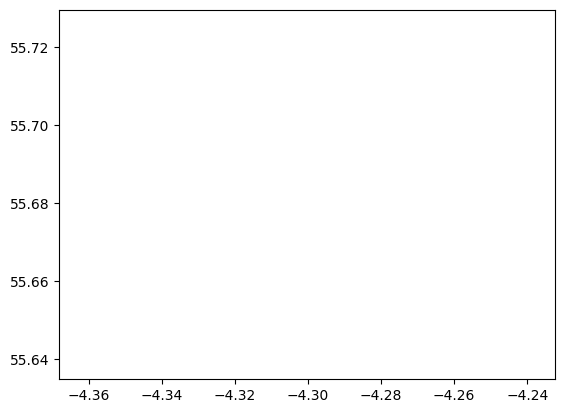

In [13]:
generate_map(merged_dataset)

In [15]:
merged_dataset.sum()

<xarray.Dataset>
Dimensions:  ()
Coordinates:
    hour     int64 0
Data variables:
    net      float64 0.0